# SRB Gaussian fit try
Looking for SRB limit division

In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from matplotlib import cm, colors
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate
from scipy.stats import norm
import sklearn.mixture

%matplotlib inline

## Load Dataset

In [2]:
path = '../datasets/preprocessed/'
rat = pd.read_hdf(path+'velocityDatabase.h5', 'Rat_Behavior').set_index('index')
rat.head(3)

,Frame,Time,X_Pos,Y_Pos,Z_Pos,X_Ori,Y_Ori,Z_Ori,session_id,Filtered,Theta,U,U_var
index,,,,,,,,,,,,,
1,21,0.087500,-0.056324,0.072395,-0.049580,-0.630137,-0.768168,0.025253,0,1,-87.705039,156.977244,NaN
2,22,0.091667,-0.056285,0.072442,-0.049525,-0.630120,-0.767833,0.032642,0,1,-87.034598,160.892886,NaN
3,23,0.095833,-0.056241,0.072488,-0.049468,-0.629928,-0.767622,0.040258,0,1,-86.343297,165.938758,NaN


In [3]:
stim = pd.read_hdf(path+'relationalDatabase.h5', 'Events').set_index('index')
stim.drop(labels=['MotiveExpTimeSecs'], axis=1, inplace=True)

stim.head()

,Frame,Time,visible,speed,session_id
index,,,,,
0,0,0.000000,0,0.0,0
1,0,0.000000,0,0.0,0
2,1,0.004167,0,0.0,0
3,2,0.008333,0,0.0,0
4,3,0.012500,0,0.0,0


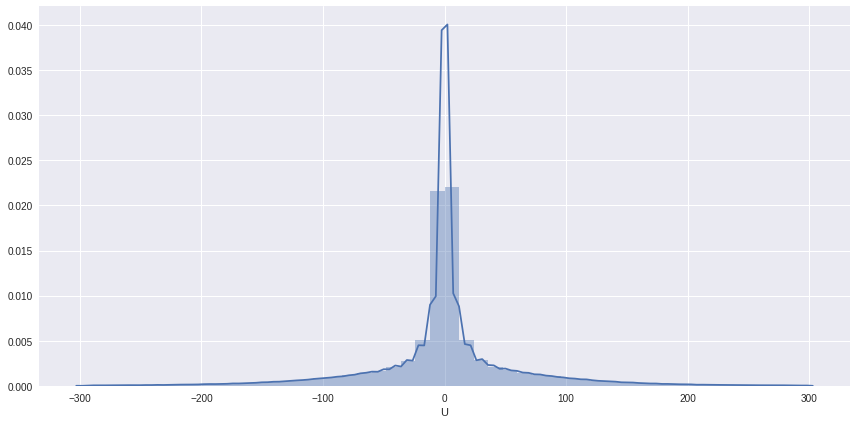

In [4]:
g = sns.FacetGrid(data=rat, size=6, aspect=2)
g.map(sns.distplot, 'U')

## Visualize Relationship between Data and Stimulus

In [5]:
rat_s = pd.merge(rat, stim, on=['Frame', 'Time', 'session_id'])
rat_s.head()

,Frame,Time,X_Pos,Y_Pos,Z_Pos,X_Ori,Y_Ori,Z_Ori,session_id,Filtered,Theta,U,U_var,visible,speed
0,21,0.087500,-0.056324,0.072395,-0.049580,-0.630137,-0.768168,0.025253,0,1,-87.705039,156.977244,NaN,0,0.0
1,22,0.091667,-0.056285,0.072442,-0.049525,-0.630120,-0.767833,0.032642,0,1,-87.034598,160.892886,NaN,0,0.0
2,23,0.095833,-0.056241,0.072488,-0.049468,-0.629928,-0.767622,0.040258,0,1,-86.343297,165.938758,NaN,0,0.0
3,24,0.100000,-0.056195,0.072532,-0.049408,-0.629630,-0.767440,0.048207,0,1,-85.621766,173.153665,NaN,0,0.0
4,25,0.104167,-0.056142,0.072577,-0.049344,-0.629153,-0.767353,0.056476,0,1,-84.870594,180.266748,NaN,0,0.0


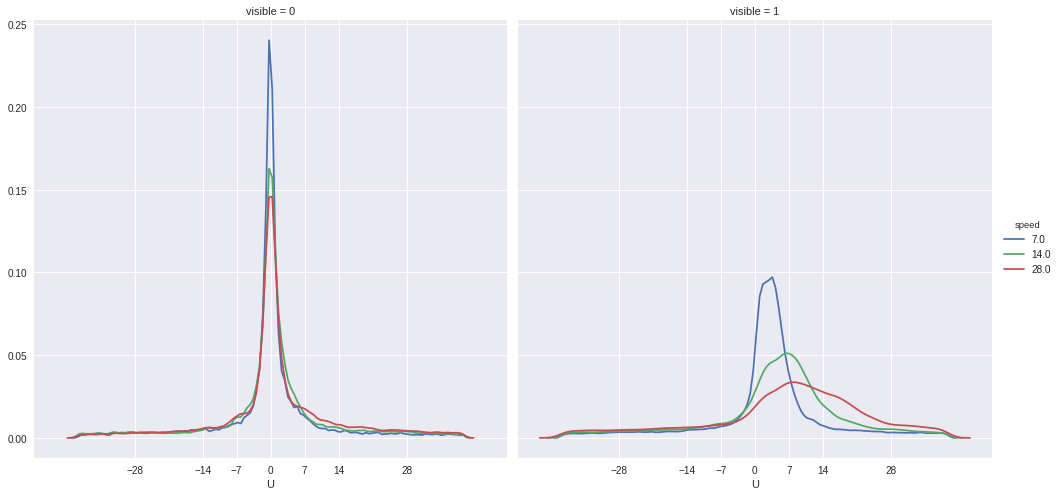

In [6]:
# mask = (0.5 < rat_sv.U) & (rat_sv.U < 40) & (rat_sv.speed >= 0)
mask = (np.abs(rat_s.U) >= 0) & (np.abs(rat_s.U) < 40) & (rat_s.speed > 0)

g = sns.FacetGrid(data=rat_s[mask], hue='speed', col='visible', size=7)
g.map(sns.kdeplot, 'U').add_legend()
g.set(xticks=[-28, -14, -7, 0, 7, 14, 28])#, yscale='log')
# g.map(plt.axvline, x=28, alpha=1, linewidth=1, color='red');

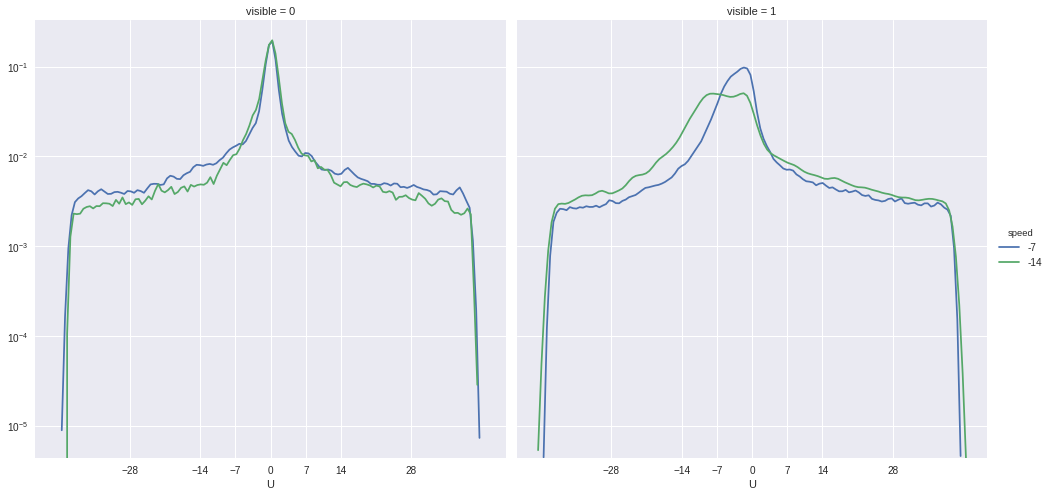

In [7]:
# mask = (0.5 < rat_sv.U) & (rat_sv.U < 40) & (rat_sv.speed >= 0)
mask = (np.abs(rat_s.U) >= 0) & (np.abs(rat_s.U) < 40) & (rat_s.speed < 0) 

g = sns.FacetGrid(data=rat_s[mask], hue='speed', col='visible', hue_order=[-7, -14], size=7)
g.map(sns.kdeplot, 'U').add_legend()
g.set(xticks=[-28, -14, -7, 0, 7, 14, 28], yscale='log')
# g.map(plt.axvline, x=28, alpha=1, linewidth=1, color='red');

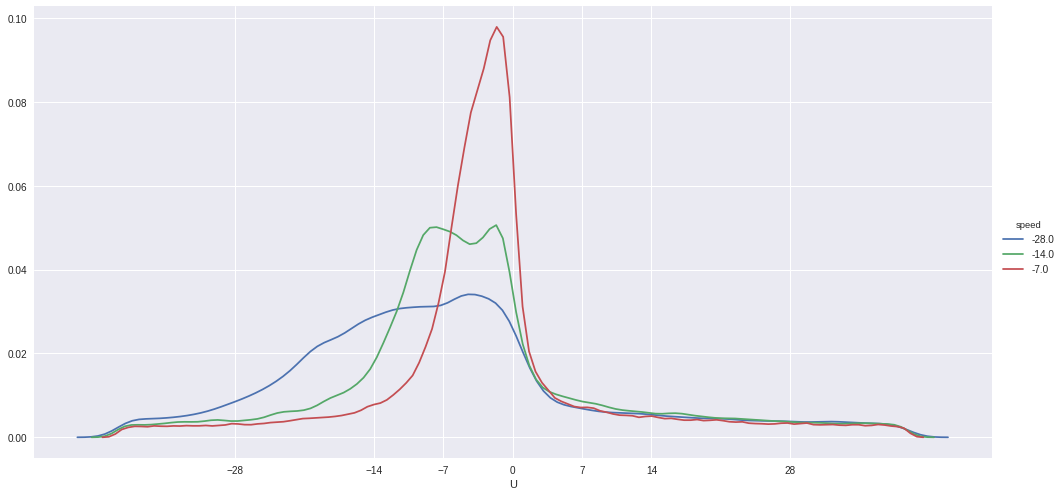

In [8]:
mask2 = (rat_s.visible == True) & (np.abs(rat_s.U) < 40) & (rat_s.speed < 0) & (np.abs(rat_s.U) >= 0) 
g = sns.FacetGrid(data=rat_s[mask2], hue='speed', size=7, aspect=2 )
g.map(sns.kdeplot, 'U').add_legend()
g.set(xticks=[-28, -14, -7, 0, 7, 14, 28])#, yscale='log')

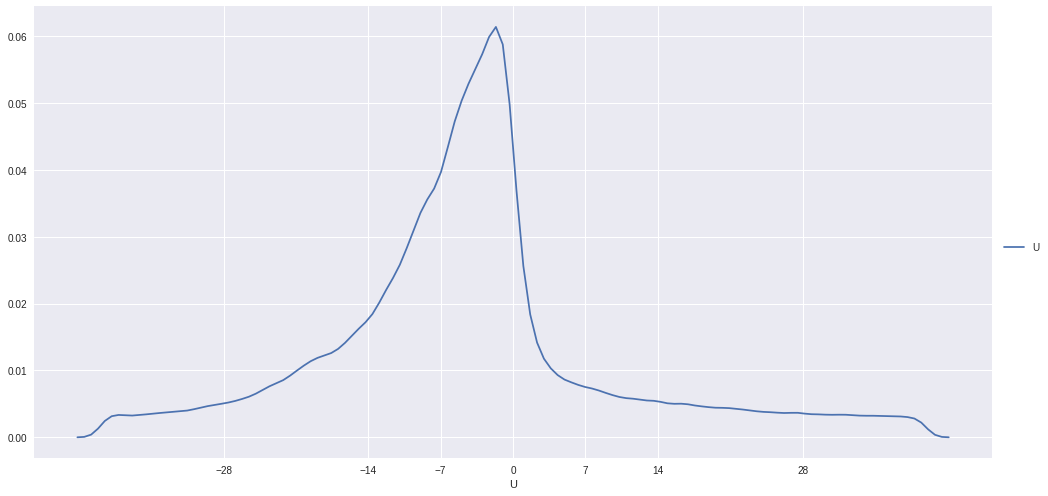

In [9]:
g = sns.FacetGrid(data=rat_s[mask2], size=7, aspect=2 )
g.map(sns.kdeplot, 'U').add_legend()
g.set(xticks=[-28, -14, -7, 0, 7, 14, 28])#, yscale='log')

## Trying it on rat velocity data

### All event evelocities

In [45]:
mask3 = (rat_s.visible == True) & (np.abs(rat_s.U) < 40) & (rat_s.speed != 0) & (np.abs(rat_s.U) != 0) 
data = rat_s[mask3].reset_index().U
data.head()

0    -8.612539
1    -6.554320
2    -2.064002
3    27.009673
4    27.457899
Name: U, dtype: float64

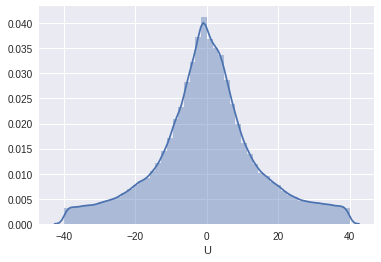

In [46]:
sns.distplot(data)

In [49]:
# fit models with 1-10 components
N = np.arange(1, 8)
models = [None for i in range(len(N))]

data = data.reshape(-1, 1)

for i in range(len(N)):
    models[i] = sklearn.mixture.GaussianMixture(N[i]).fit(data)

# compute the AIC and the BIC
AIC = [m.aic(data) for m in models]
BIC = [m.bic(data) for m in models]

fitted = models[np.argmin(BIC)]

### Fit for 7 components
Including speed = 0

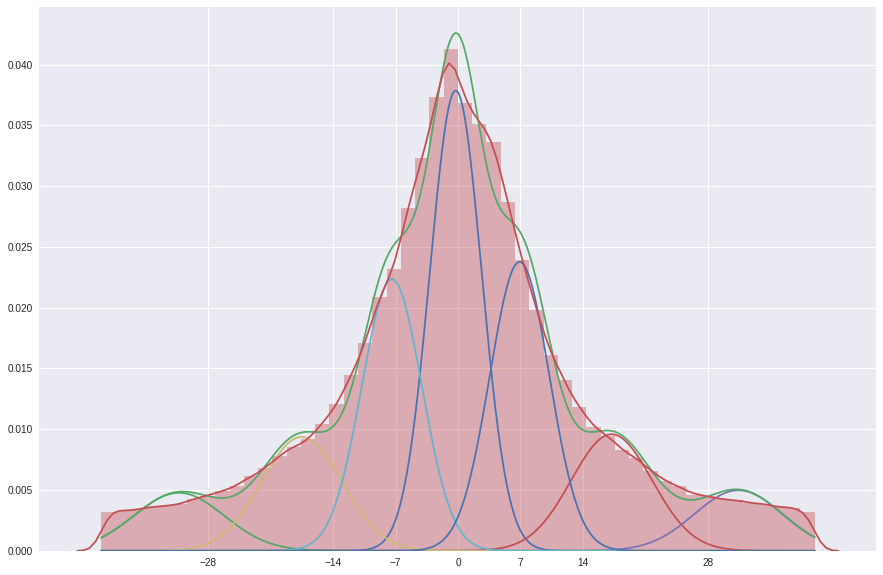

In [50]:
data_range = np.arange(data.min(),data.max(),0.01)
mixture = np.arange(data.min(),data.max(),0.01) * 0

fig, ax = plt.subplots(figsize=(15, 10));
ax.set_xticks([-28, -14, -7, 0 , 7, 14, 28]);

for ind in range(fitted.n_components):

    weight = fitted.weights_[ind]
    mean = fitted.means_[ind, 0]
    var = np.sqrt(fitted.covariances_[ind, 0, 0])  # scipy pdf function accepts std and not variance
    
    plt.plot(np.arange(data.min(),data.max(),0.01), weight * norm.pdf(data_range, mean, var))
    
    mixture += weight * norm.pdf(data_range, mean, var)
    

plt.plot(np.arange(data.min(),data.max(),0.01), mixture);
sns.distplot(data);

### Fit for 6 components
all speeds different then 0

In [51]:
data = data.reshape(-1, 1)
model = sklearn.mixture.GaussianMixture(6).fit(data)
fitted = model

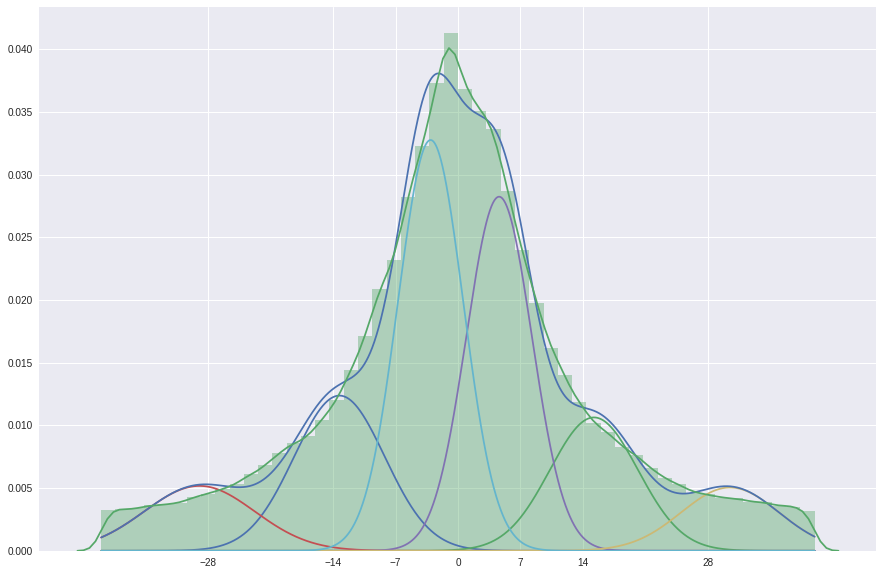

In [52]:
data_range = np.arange(data.min(),data.max(),0.01)
mixture = np.arange(data.min(),data.max(),0.01) * 0

fig, ax = plt.subplots(figsize=(15, 10));
ax.set_xticks([-28, -14, -7, 0 , 7, 14, 28]);

for ind in range(fitted.n_components):
    weight = fitted.weights_[ind]
    mean = fitted.means_[ind, 0]
    var = np.sqrt(fitted.covariances_[ind, 0, 0])  # scipy pdf function accepts std and not variance
    
    plt.plot(np.arange(data.min(),data.max(),0.01), weight * norm.pdf(data_range, mean, var))
    
    mixture += weight * norm.pdf(data_range, mean, var)
    

plt.plot(np.arange(data.min(),data.max(),0.01), mixture);
sns.distplot(data);

### Positive event velocities

In [24]:
maskplus = (rat_s.visible == True) & (np.abs(rat_s.U) < 40) & (rat_s.speed > 0) & (rat_s.U > 0) 
data = rat_s[maskplus].reset_index().U
data.head()

0    27.009673
1    27.457899
2    25.696553
3    22.880223
4    19.658606
Name: U, dtype: float64

In [27]:
# fit models with 1-10 components
N = np.arange(1, 4)
models = [None for i in range(len(N))]

data = data.reshape(-1, 1)

for i in range(len(N)):
    models[i] = sklearn.mixture.GaussianMixture(N[i]).fit(data)

# compute the AIC and the BIC
AIC = [m.aic(data) for m in models]
BIC = [m.bic(data) for m in models]

fitted = models[np.argmin(BIC)]


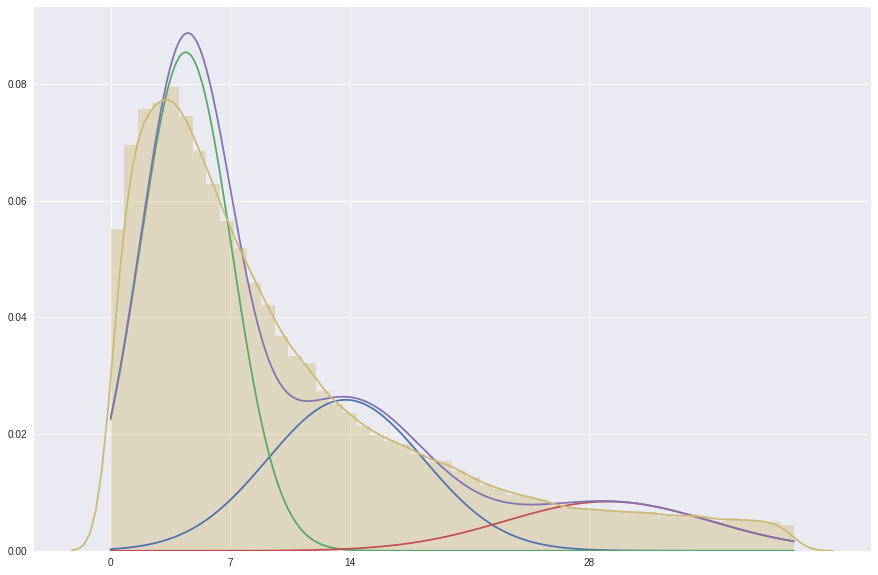

In [28]:
data_range = np.arange(data.min(),data.max(),0.01)
mixture = np.arange(data.min(),data.max(),0.01) * 0

fig, ax = plt.subplots(figsize=(15, 10));
ax.set_xticks([-28, -14, -7, 0 , 7, 14, 28]);

for ind in range(fitted.n_components):

    weight = fitted.weights_[ind]
    mean = fitted.means_[ind, 0]
    var = np.sqrt(fitted.covariances_[ind, 0, 0])  # scipy pdf function accepts std and not variance
    
    plt.plot(np.arange(data.min(),data.max(),0.01), weight * norm.pdf(data_range, mean, var))
    
    mixture += weight * norm.pdf(data_range, mean, var)
    

plt.plot(np.arange(data.min(),data.max(),0.01), mixture);
sns.distplot(data);

## Negative event velocities

In [38]:
maskplus = (rat_s.visible == True) & (np.abs(rat_s.U) < 40) & (rat_s.speed <0) & (rat_s.U < 0) 
data = rat_s[maskplus].reset_index().U
data.head()

0   -1.662344
1   -3.488748
2   -5.078527
3   -6.497916
4   -6.504949
Name: U, dtype: float64

In [41]:
# fit models with 1-10 components
N = np.arange(1, 4)
models = [None for i in range(len(N))]

data = data.reshape(-1, 1)

for i in range(len(N)):
    models[i] = sklearn.mixture.GaussianMixture(N[i]).fit(data)

# compute the AIC and the BIC
AIC = [m.aic(data) for m in models]
BIC = [m.bic(data) for m in models]

fitted = models[np.argmin(BIC)]


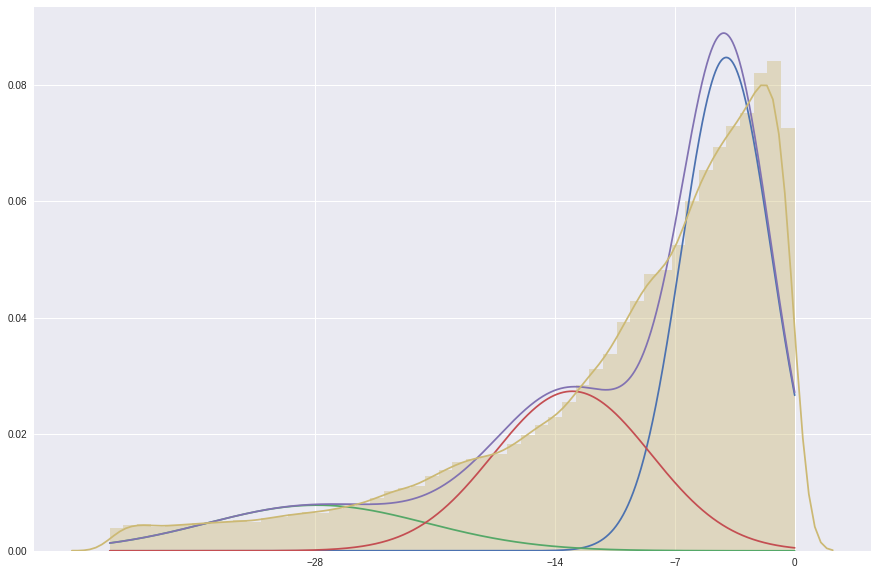

In [42]:
data_range = np.arange(data.min(),data.max(),0.01)
mixture = np.arange(data.min(),data.max(),0.01) * 0

fig, ax = plt.subplots(figsize=(15, 10));
ax.set_xticks([-28, -14, -7, 0 , 7, 14, 28]);

for ind in range(fitted.n_components):

    weight = fitted.weights_[ind]
    mean = fitted.means_[ind, 0]
    var = np.sqrt(fitted.covariances_[ind, 0, 0])  # scipy pdf function accepts std and not variance
    
    plt.plot(np.arange(data.min(),data.max(),0.01), weight * norm.pdf(data_range, mean, var))
    
    mixture += weight * norm.pdf(data_range, mean, var)
    

plt.plot(np.arange(data.min(),data.max(),0.01), mixture);
sns.distplot(data);